# Project 2 - Community detection in an academic network
## Aim
<ol>
  <li> Load social graph</li>
  <li> Run community detection and centrality methods</li>
  <li> Visualize the network </li>
</ol>

## Tasks
<ol>
    <li> <strong>Load the dataset:</strong> Load the Author Network dataset provided at <a href:"https://aminer.org/lab-datasets/soinf/">https://aminer.org/lab-datasets/soinf/</a>
The graph consists of authors and coauthor relationships.
  </li>
    <li> <strong>Implementation:</strong> 
        <ol>
            <li> Implement Girvan-Newman clustering algorithm till 10th iteration level.</li>
            <li> Implement Pagerank algorithm.</li>
            <li> Implement Betweenness centrality measure</li>
        <strong>Use the previous implementation, perform the following tasks</strong>
            <li> Use Girvan-Newman algorithm to find clusters of authors</li>
            <li> Find the top-10 authors with highest betweenness centrality</li>      
        </ol>
    </li>
    <li> <strong>Visualization: </strong> 
        <ol>
            <li> Visualize the output of Girvan-Newman algorithm by coloring nodes according to their assigned groups</li>
            <li> Visualize the network and highlight the top 10 authors with the highest betweeness centrality and top 10 edges with the highest betweenness centrality</li>      
        </ol>
    </li>


# 1. Load the dataset

In [1]:
# Import Modules
import networkx as nx
from pprint import pprint
import operator
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import math
import random
from matplotlib.gridspec import GridSpec

# Utility class to pretty print dictionary
class DictTable(dict):
    # Overridden dict class which takes a dict in the form {'a': 2, 'b': 3},
    # and renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        html = ["<table width=100%>"]
        for key, value in iter(self.items()):
            html.append("<tr>")
            html.append("<td>{0}</td>".format(key))
            html.append("<td>{0}</td>".format(str(len(value))+" "+"graph[s] of size: "+str([len(x) for x in value])+" nodes"))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
print("> All necessary modules imported")

> All necessary modules imported


In [2]:
# Load Data
DATASET = "./data"

def loadData(directoryPath):
    """Load the data of all files of the folder given in parameter."""
    files = os.listdir(directoryPath)
    # dictionary wrt to the following format: {topic1:[[network1],[network2]]}
    allGraphsOfEachTopic = {}
    for file in files:
        topic = ""
        if "T107" in file:
            topic = "Web Services"
        elif "T131" in file:
            topic = "Bayesian Networks/Belief function"
        elif "T144" in file:
            topic = "Web Mining/Information Fusion"
        elif "T145" in file:
            topic = "Semantic Web/Description Logics"
        elif "T162" in file:
            topic = "Machine Learning"
        elif "T16" in file:
            topic = "Data Mining/Association Rules"
        elif "T24" in file:
            topic = "Database Systems/XML Data"
        elif "T75" in file:
            topic = "Information Retrieval"
        else:
            topic = "Unknown"

        graphToBuild = nx.Graph()
        
        # for naming purposes
        subStart = file.find('sub')
        subEnd = file.find('.')
        graphToBuild.name = topic.replace('/', ' ').replace(' ', '') + '_{}'.format(file[subStart:subEnd])

        # constant
        VERTEX = 0
        EDGE = 1
        TRIANGLE = 2

        f = open(DATASET+"/"+file)

        # Vertices: Int "String" Int -> NodeID, personName, #papers
        # Edges: Int Int Int -> sourceNodeID, DestNodeID, #coauthoredPapers
        # Triangles: Int,Int,Int,Int -> NodeID1, NodeID2, NodeID3, #coauthoredPapers
        for line in f:
            if "*Vertices" in line:
                typeOfLine = VERTEX
            elif "*Edges" in line:
                typeOfLine = EDGE
            elif "*Triangles" in line:
                typeOfLine = TRIANGLE
            else:
                if typeOfLine == VERTEX:
                    graph_edge_list = []
                    
                    for index, s in enumerate(re.split('"', line)):
                        if (index == 1):
                            graph_edge_list.append(s)
                        else:
                            graph_edge_list.append(s.replace(' ','').replace('\n', ''))
                            
                    graphToBuild.add_node(graph_edge_list[0], name=graph_edge_list[1], nbpapers=graph_edge_list[2])
                elif typeOfLine == EDGE:
                    graph_edge_list = line.split()
                    graphToBuild.add_edge(graph_edge_list[0], graph_edge_list[1], coauthoredPapers=graph_edge_list[2])
                elif typeOfLine == TRIANGLE:
                    graph_edge_list = line.split(',')
                    graph_edge_list[3] = graph_edge_list[3].replace('\n', '')
                    graphToBuild.add_edge(graph_edge_list[0], graph_edge_list[1], coauthoredPapersTriangle=graph_edge_list[3])
                    graphToBuild.add_edge(graph_edge_list[0], graph_edge_list[2], coauthoredPapersTriangle=graph_edge_list[3])
                    graphToBuild.add_edge(graph_edge_list[1], graph_edge_list[2], coauthoredPapersTriangle=graph_edge_list[3])

        if topic in allGraphsOfEachTopic:
            allGraphsOfEachTopic[topic].append(graphToBuild)
        else:
            allGraphsOfEachTopic[topic] = [graphToBuild]

    return allGraphsOfEachTopic

allData = loadData(DATASET)
print("> All data loaded")
DictTable(allData)

> All data loaded


Web Mining/Information Fusion,"3 graph[s] of size: [9, 348, 11] nodes"
Information Retrieval,"2 graph[s] of size: [7, 657] nodes"
Web Services,"2 graph[s] of size: [400, 7] nodes"
Semantic Web/Description Logics,"2 graph[s] of size: [671, 10] nodes"
Database Systems/XML Data,1 graph[s] of size: [1127] nodes
Machine Learning,1 graph[s] of size: [976] nodes
Bayesian Networks/Belief function,1 graph[s] of size: [554] nodes
Data Mining/Association Rules,1 graph[s] of size: [679] nodes


# 2. Implementation
## 2A. Implementation of Girvan-Newman clustering till 10th iteration level

In [3]:
def listAuthorsClusters(G):
    if not os.path.exists('./Output/GirvanNewman/ClustersTxt'):
        os.makedirs('./Output/GirvanNewman/ClustersTxt')
    
    connected_components = nx.connected_component_subgraphs(G)
    
    f = open('./Output/GirvanNewman/ClustersTxt/{}.txt'.format(G.name), 'w')
    for index, sg in enumerate(connected_components):
        f.write('######## Cluster {:2} #######\n'.format(index))
        for node in sg.nodes:
            f.write('> {}\n'.format(G.node[node]['name']))
        f.write('\n\n')
    f.close()
    
    
    
def findConcernedEdges(pathsThatContainKey, highestEdge):
    ''' Finds which edges are impacted by the removal of the edge that has the highest centrality'''
    concernedPaths = []
    for path in pathsThatContainKey[highestEdge[0]]:
        try:
            index = path.index(highestEdge[0])
            if path[index + 1] == highestEdge[1]:
                concernedPaths.append(path)
        except:
            pass
    #print('Concerned PATHS: ', concernedPaths)
    concernedEdges = []
    # create tuples from paths: ['1','5','7','3'] -> [('1','5'),('5','7'),('7','3')]
    for path in concernedPaths:
        y = path[1:]
        concernedEdges += list(zip(path, y))
        
    # remove duplicates
    concernedEdges = list(dict.fromkeys(concernedEdges))
    
    # reorder edges. Otherwise, ('6','11') would be different from ('11','6').
    concernedEdges = [(y,x) if int(y) < int(x) else (x,y) for (x,y) in concernedEdges]
    
    # remove highestEdge in order not to recompute its centrality afterwards (it will be 0).
    concernedEdges.remove(highestEdge)

    return concernedEdges

def girvanNewmanClustering(graph, nbIteration, visualization = False):
    print('Girvan-Newman on graph "{}", {} iterations'.format(graph.name, nbIteration))
    
    if visualization == True:
         # Draw first plot in figure and use variable cnt to handle positions
        fig = plt.figure(figsize=(50, 50))
        drawGraphs(graph, 1)
        cnt = 2
   
    # removed edge -> to be returned
    top10Edges = list()
    
    # If there are no edge in the graph
    if len(list(graph.edges)) == 0:
        return "Empty graph"
    
    # At the beginning, we need to compute the centrality for all edges. So all edges are "concerned"
    concernedEdges = list(graph.edges)
    
    # init centralities dictionary: {edge: [centrality (for sorting purposes), edge]}
    centralities = {}

    # While there are edges in the graph and that the number of iteration is biggger than 0
    while(len(list(graph.edges)) > 0 and nbIteration > 0):
        #firstIteration = True
        print("Remaining iterations: ", nbIteration)
        nbIteration = nbIteration - 1
        
        # Get all edges of the current graph
        edges = list(graph.edges)
        
        # Compute all shortest paths
        shortestPaths = list(nx.all_pairs_shortest_path(graph))
        
        if len(shortestPaths) ==0:
            break

        # basic list containing each shortest path -> [path1, path2, path3, ..., pathN]
        allShortestPaths = []

        # dictionary that links a node to all paths in which it appears -> {'1': [listOfPaths], ...}
        pathsThatContainKey = {}

        for index, vi in enumerate(shortestPaths):
            pathsThatContainKey[str(index + 1)] = []
            values = list(vi[1].values())

            for path in values:
                allShortestPaths.append(path)
                for elem in path:
                    pathsThatContainKey.setdefault(elem, []).append(path)

                    
        #print('CONCERNED EDGES: ', concernedEdges)
        for edge in concernedEdges:
            # recompute centrality only for edges whose centrality value changes
            # first iteration -> all edges
            centrality = edgesBetweennessCentrality(allShortestPaths, pathsThatContainKey, edge)
            centralities[edge] = [centrality, edge]
            
        #print(sorted(centralities.values(), reverse=True))
        
        # get edge with the highest centrality and the centrality value
        highestScore, highestEdge = sorted(centralities.values(), reverse=True)[0]
        #print('HIGHEST EDGE: ', highestEdge, highestScore)
        
        # find the edges impacted with the removal of 'highestEdge'
        concernedEdges = findConcernedEdges(pathsThatContainKey, highestEdge)
        
        # add edge to be removed to top10Edges
        top10Edges.append(highestEdge)
        
        # Remove the edge with the highest centrality
        graph.remove_edge(highestEdge[0], highestEdge[1])
        rmvd = centralities.pop(highestEdge, None)
        #print('Removed from centrality dictionary', rmvd)
        
        if visualization == True:
            # Draw the graph with the removed edge into the figure
            drawGraphs(graph, cnt)
            cnt += 1
        
    
    if visualization == True:
        # Draw the original graph with colors to detect communities and save the figure
        print("Drawing...")
        drawColoredGraph(graph)
        print("Drawing done")
        if not os.path.exists('./Output/GirvanNewman/Figures'):
            os.makedirs('./Output/GirvanNewman/Figures')
    
        plt.savefig("./Output/GirvanNewman/Figures/{}.png".format(graph.name))
        print("> Figure saved")
    
    print('Saving clusters composition...')
    listAuthorsClusters(graph)
    print('> Clusters composition saved')    
    
    return top10Edges

# <span style="color:magenta">**Je teste ci-dessous poulet, faut voir l'output pour voir si ça tient la route** </span>

In [6]:
# test
top10EdgesPerGraph = dict()
graph = allData['Web Mining/Information Fusion'][0]
topEdges = girvanNewmanClustering(graph.copy(),10)
top10EdgesPerGraph[graph.name] = topEdges
print(top10EdgesPerGraph)

Girvan-Newman on graph "WebMiningInformationFusion_sub27", 10 iterations
Remaining iterations:  10
Remaining iterations:  9
Remaining iterations:  8
Remaining iterations:  7
Remaining iterations:  6
Remaining iterations:  5
Remaining iterations:  4
Remaining iterations:  3
Remaining iterations:  2
Remaining iterations:  1
Saving clusters composition...
> Clusters composition saved
{'WebMiningInformationFusion_sub27': [('2', '7'), ('8', '9'), ('6', '9'), ('5', '7'), ('1', '7'), ('4', '7'), ('7', '9'), ('3', '9'), ('2', '9'), ('2', '3')]}


## 2B. Implementation of Pagerank algorithm

In [4]:
def pageRankCentrality(graph, alpha, beta):
    # Transposition of matrix
    adjacencyMatrix = nx.to_numpy_matrix(graph, weight='None')
    amTransposed = np.transpose(adjacencyMatrix)

    # Diagonal Matrix
    diagonalMatrix = np.zeros([adjacencyMatrix.shape[0], adjacencyMatrix.shape[1]])
    row, col = np.diag_indices(diagonalMatrix.shape[0])
    # Compute the values that have to be filled into the diagonal
    diagonalMatrix[row, col] = [1 / degree[1] for degree in list(graph.degree())]

    # Identity matrix
    identityMatrix = np.identity(adjacencyMatrix.shape[0])

    # Vector of ones
    ones = np.ones((adjacencyMatrix.shape[0], 1))
    pageRankCentrality = np.dot(beta * np.linalg.inv((identityMatrix - np.dot(alpha * amTransposed, diagonalMatrix))), ones)

    return pageRankCentrality



## 2C. Implementation of the betweenness centrality measure

In [5]:
def edgesBetweennessCentrality(allShortestPaths, pathsThatContainKey, edge):
    """computes the betweenness centrality of a given edge"""
    # Initialization of variables to compute centrality of each edge
    #centrality=0
    nbPathsIncludingEdge=0
    #counterShortestPath=0
            
    # For all shortestPath, count the number of them that contain the current edge 
    #for vi in allShortestPaths:
        #nbPathsIncludingEdge += edgeIsInPath([edge[0], edge[1]], vi)
        #nbPathsIncludingEdge += edgeIsInPath(edge, allShortestPaths, pathsThatContainKey)
        #counterShortestPath+=1
            
    for index, p in enumerate(pathsThatContainKey[edge[0]]):
        try:
            index = p.index(edge[0])
            if p[index + 1] == edge[1]:
                nbPathsIncludingEdge += 1
                continue
                
            # case where the edge is in reversed order ('11', '6') instead of ('6', '11')
            # It should never be the case but it is still better to test it
            index = p.index(edge[1])
            if p[index + 1] == edge[0]:
                nbPathsIncludingEdge += 1
        except:
            pass
    
    
    # Centrality = Number of shortest paths including the edge / total number of shortest paths       
    centrality = nbPathsIncludingEdge / len(allShortestPaths)
    #print(nbPathsIncludingEdge, len(allShortestPaths), centrality)
    return centrality

#def edgeIsInPath(edge, path):
#    """checks if an edge is contained in a path of an undirected graph (the path is a list of nodes)"""
#    edge1= [edge[0],edge[1]]
#    edge2= [edge[1],edge[0]]
#    print('edge 1: {}, edge 2: {}, path: {}'.format(edge1, edge2, path))
#    if all(i in path for i in edge1) or all(i in path for i in edge2):
#        return 1
#    else:
#        return 0

    
def nodeIsInPath(node, path):
    """checks if an edge is contained in a path of an undirected graph (the path is a list of nodes)"""
    if node in path:
        return 1
    else:
        return 0
    
def nodesBetweennessCentrality(listOfAllShortestPath, node, graph):
    """betweenness centrality of a given node: used in task 2E"""
    centrality = 0
    nbPathsIncludingNode=0
    counterShortestPath=0
    
    for vi in listOfAllShortestPath:
        nbPathsIncludingNode += nodeIsInPath(node, vi)
        counterShortestPath+=1
        
    centrality = nbPathsIncludingNode/counterShortestPath
    return centrality

## 2D. Use Girvan-Newman algorithm to find clusters of authors

In [11]:
top10EdgesPerGraph = dict()

# runs Girvan-Newman for every graph in the dataset
for topic, listOfGraphs in allData.items():
    print('>>> Topic "{}""'.format(topic))
    for graph in listOfGraphs:
        print('> Girvan-Newman clustering for {}'.format(graph.name))
        topEdges = girvanNewmanClustering(graph.copy(), 10)
        top10EdgesPerGraph[graph.name] = topEdges

>>> Topic "Web Mining/Information Fusion""
> Girvan-Newman clustering for WebMiningInformationFusion_sub27
Girvan-Newman on graph "WebMiningInformationFusion_sub27", 10 iterations
Remaining iterations:  10
Remaining iterations:  9
Remaining iterations:  8
Remaining iterations:  7
Remaining iterations:  6
Remaining iterations:  5
Remaining iterations:  4
Remaining iterations:  3
Remaining iterations:  2
Remaining iterations:  1
Saving clusters composition...
> Clusters composition saved
> Girvan-Newman clustering for WebMiningInformationFusion_sub4
Girvan-Newman on graph "WebMiningInformationFusion_sub4", 10 iterations
Remaining iterations:  10
Remaining iterations:  9
Remaining iterations:  8
Remaining iterations:  7
Remaining iterations:  6
Remaining iterations:  5
Remaining iterations:  4
Remaining iterations:  3
Remaining iterations:  2
Remaining iterations:  1
Saving clusters composition...
> Clusters composition saved
> Girvan-Newman clustering for WebMiningInformationFusion_sub6


KeyboardInterrupt: 

## 2E. Find the top-10 authors with highest betweenness centrality

In [10]:
# prints the top-10 authors for each graph of the dataset
top10NodesPerGraph = dict()

for topic, listOfGraphs in allData.items():
    print('Topic "{}""'.format(topic))
    for graph in listOfGraphs:
        results = []
        allShortestPaths = []
        for index, vi in enumerate(np.asarray(list(nx.all_pairs_shortest_path(graph)))):
            test = list(vi[1].values())
            test2= sorted(test, key=lambda x: int(x[-1]))[index+1:]
            for path in test2:
                allShortestPaths.append(path)
        for node in graph.nodes:
            results.append( (nodesBetweennessCentrality(allShortestPaths, node, graph), graph.node[node]['name'], node) )
        
        top10NodesPerGraph[graph.name] = [node[2] for node in sorted(results, reverse=True)[:10]]
        
        print('Top-10 authors for {}'.format(graph.name))
        for tuple in sorted(results, reverse=True)[:10]:
            print('>>> {}'.format(tuple))
        print('\n')

Topic "Web Mining/Information Fusion""
Top-10 authors for WebMiningInformationFusion_sub27
>>> (0.5833333333333334, 'Vaclav Snasel', '9')
>>> (0.5555555555555556, 'Vojtech Svatek', '7')
>>> (0.3333333333333333, 'Tomas Skopal', '2')
>>> (0.2222222222222222, 'Pavel Moravec', '3')
>>> (0.2222222222222222, 'Michal Kratky', '1')
>>> (0.2222222222222222, 'Josef Petrak', '5')
>>> (0.2222222222222222, 'Jan Nemrava', '4')
>>> (0.2222222222222222, 'Jan Martinovic', '8')
>>> (0.2222222222222222, 'Ales Keprt', '6')




KeyboardInterrupt: 

In [8]:
########## TEST
top10NodesPerGraph = dict()

graph = allData['Web Mining/Information Fusion'][1]
results = []
allShortestPaths = []
for index, vi in enumerate(np.asarray(list(nx.all_pairs_shortest_path(graph)))):
    test = list(vi[1].values())
    test2= sorted(test, key=lambda x: int(x[-1]))[index+1:]
    for path in test2:
        allShortestPaths.append(path)
for node in graph.nodes:
    results.append( (nodesBetweennessCentrality(allShortestPaths, node, graph), graph.node[node]['name'], node) )

top10NodesPerGraph[graph.name] = [node[2] for node in sorted(results, reverse=True)[:10]]

print('Top-10 authors for {}'.format(graph.name))
for tuple in sorted(results, reverse=True)[:10]:
    print('>>> {}'.format(tuple))
print('\n')

Top-10 authors for WebMiningInformationFusion_sub4
>>> (0.3243068667395409, 'Steffen Staab', '162')
>>> (0.2622147139686641, 'Maristella Matera', '10')
>>> (0.2352346881314386, 'Wolfgang Nejdl', '348')
>>> (0.15118089370300442, 'C. Lee Giles', '28')
>>> (0.1324489052303819, 'Krishna Bharat', '60')
>>> (0.1270992745702077, 'Geert-Jan Houben', '201')
>>> (0.12701646295008115, 'Dieter Fensel', '56')
>>> (0.12428367948590546, 'Ricardo A. Baeza-Yates', '260')
>>> (0.11976216502699659, 'Oliver Spatscheck', '120')
>>> (0.10028487197323528, 'Prasenjit Mitra', '106')




In [ ]:
# Example with a single graph: TO DELETE FOR THE FINALE VERSION BUT IS CURRENTLY A PROOF THAT THE ALGORITHM WORKS 
                            #AS IS PRODUCES THE SAME RESULT THAN THE NETWORKX FUNCTION 
graph = allData["Web Mining/Information Fusion"][2].copy()
print("Here are the results given by networkX \n",nx.betweenness_centrality(graph,endpoints=True))
results = []

allShortestPaths = []
for index, vi in enumerate(np.asarray(list(nx.all_pairs_shortest_path(graph)))):
    test = list(vi[1].values())
    test2= sorted(test, key=lambda x: int(x[-1]))[index+1:]
    for path in test2:
        allShortestPaths.append(path)
        
for node in graph.nodes:
    results.append( (nodesBetweennessCentrality(allShortestPaths, node, graph), graph.node[node]['name']) )
print('Top-10 authors for {}'.format(graph.name))
for tuple in sorted(results, reverse=True)[:10]:
    print('>>> {}'.format(tuple))


# 3. Visualization

## 3A. Visualize the output of Girvan-Newman algorithm by coloring nodes according to their assigned groups

In [30]:
def drawGraph(G):
    """draws the given graph and displays the labels of each edge"""
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True)
    nx.draw_networkx_edge_labels(G, pos)
    plt.show()

def drawGraphs(G, cnt):
    """Draws all different subgraphs on the same picture"""
    test = plt.subplot(4, 3, cnt)
    if (cnt == 1):
        test.title.set_text('Initial state of the graph')
    else:
        test.title.set_text('State of the graph at iteration: {}, number of communities: {}'.format(cnt-1, nx.number_connected_components(G)))
    test.set_yticklabels([])
    test.set_xticklabels([])
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos)
    nx.draw_networkx_edge_labels(G, pos)

def drawColoredGraph(G):
    """Draws a graph where communities are drawn using different colors"""
    test = plt.subplot(4,3,12)
    test.set_yticklabels([])
    test.set_xticklabels([])
    test.title.set_text('Resulting communities ({})'.format(nx.number_connected_components(G)))
    pos = nx.spring_layout(G)
    connected_components = nx.connected_component_subgraphs(G)
    for index, sg in enumerate(connected_components):
        r = lambda: random.randint(0,255)
        randomColor =('#%02X%02X%02X' % (r(),r(),r()))
        nx.draw_networkx(sg, pos = pos, node_color = str(randomColor), with_labels= False, edgelist=[])

def drawHighlightedGraph(G, highestEdges, highestNodes):
    """Draws a graph and highlights the nodes and edges with the highest centrality"""
    unhighlightedEdges = [e for e in G.edges if e not in highestEdges]
    unhighlightedNodes = [n for n in G.nodes if n not in highestNodes]
    
    plt.figure(figsize=(20,20))
    pos = nx.spring_layout(G)
    
    # draw unhighlighted nodes
    nx.draw_networkx_nodes(G, pos, nodelist=unhighlightedNodes, node_color='b', alpha=0.8)
    
    # draw highlighted nodes
    nx.draw_networkx_nodes(G, pos, nodelist=highestNodes, node_color='r')
    
    nx.draw_networkx_labels(G, pos, labels={node: node for node in highestNodes})
    # draw all edges
    nx.draw_networkx_edges(G,pos)
    nx.draw_networkx_edges(G, pos, edgelist=highestEdges, width=8, alpha=1, edge_color='r')
    
    plt.axis('off')
    plt.title(graph.name)
    plt.savefig("./Output/Highlighting/Figures/{}.png".format(graph.name)) # save as png
    
    plt.show()

In [ ]:
# runs Girvan-Newman for every graph in the dataset and visualize the output
for topic, listOfGraphs in allData.items():
    print('>>> Topic "{}""'.format(topic))
    for graph in listOfGraphs:
        print('> Girvan-Newman clustering for {}'.format(graph.name))
        girvanNewmanClustering(graph.copy(), 10, visualization=True)

## 3B. Visualize the network and highlight the top 10 authors with the highest betweenness centrality and top 10 edges with the highest betweenness centrality

{'WebMiningInformationFusion_sub4': ['162', '10', '348', '28', '60', '201', '56', '260', '120', '106']}
{'WebMiningInformationFusion_sub27': [('2', '7'), ('8', '9'), ('6', '9'), ('5', '7'), ('1', '7'), ('4', '7'), ('7', '9'), ('3', '9'), ('2', '9'), ('2', '3')], 'WebMiningInformationFusion_sub4': [('10', '348'), ('28', '106'), ('120', '162'), ('10', '213'), ('10', '100'), ('10', '161'), ('81', '162'), ('56', '260'), ('10', '201'), ('56', '162')], 'WebMiningInformationFusion_sub6': [('5', '6'), ('6', '11'), ('6', '10'), ('3', '6'), ('1', '4'), ('4', '9'), ('4', '5'), ('2', '6'), ('7', '10'), ('8', '11')], 'InformationRetrieval_sub5': [('1', '6'), ('5', '6'), ('5', '7'), ('4', '6'), ('1', '3'), ('1', '2'), ('2', '3')]}


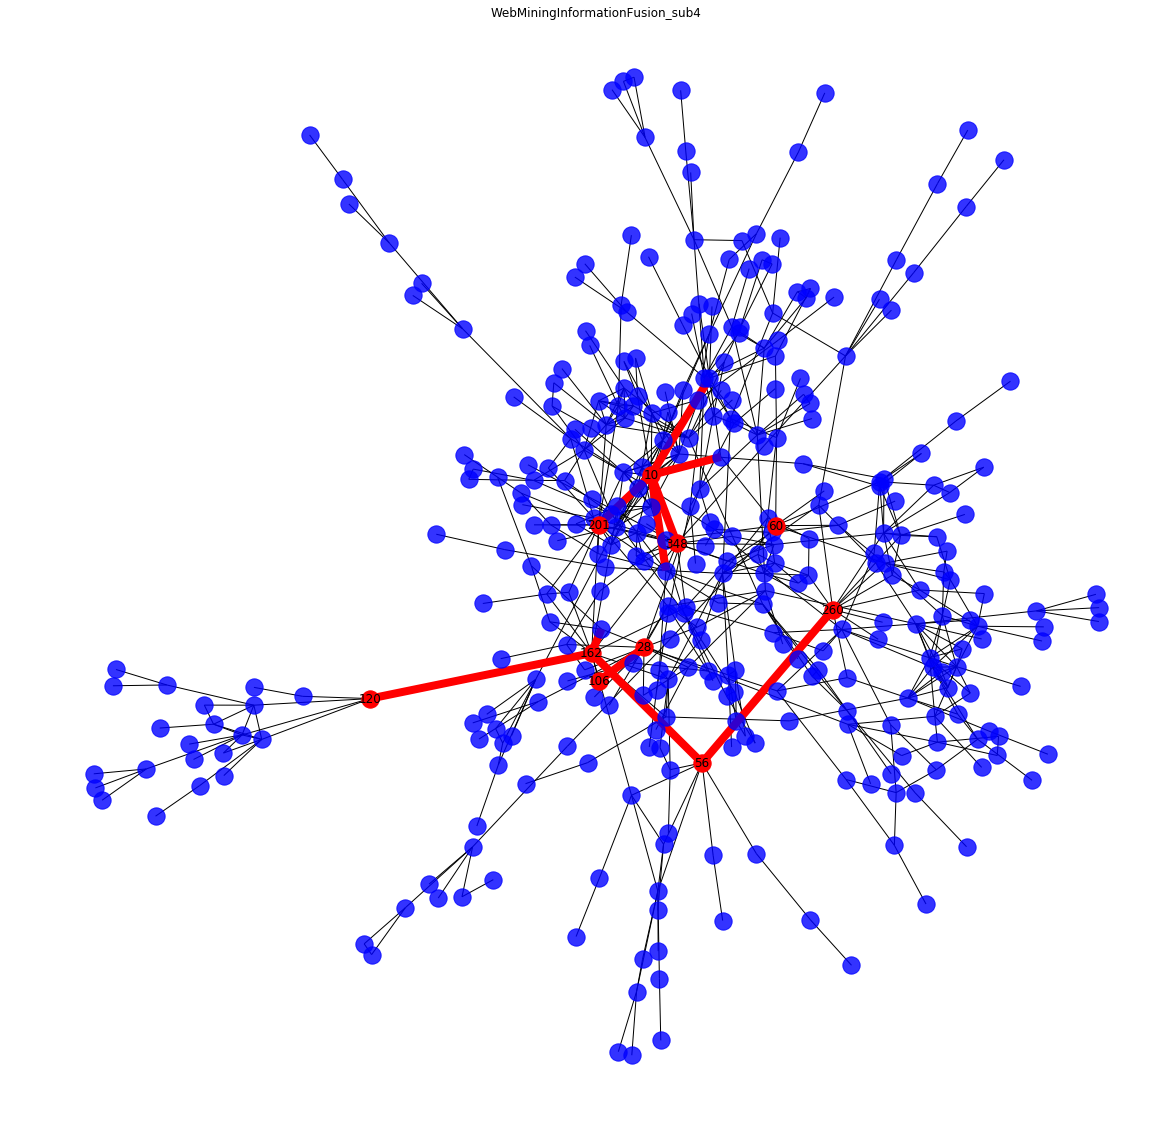

In [31]:
if not os.path.exists('./Output/Highlighting/Figures'):
        os.makedirs('./Output/Highlighting/Figures')

# test with only 1 graph
graph = allData['Web Mining/Information Fusion'][1]
print(top10NodesPerGraph)
print(top10EdgesPerGraph)
drawHighlightedGraph(graph, top10EdgesPerGraph[graph.name], top10NodesPerGraph[graph.name])

In [ ]:
# Visualization and highlighting of the network
if not os.path.exists('./Output/Highlighting/Figures'):
        os.makedirs('./Output/Highlighting/Figures')

for topic, listOfGraphs in allData.items():
    for graph in listOfGraphs:
        drawHighlightedGraph(graph, top10EdgesPerGraph[graph.name], top10NodesPerGraph[graph.name]):